# Predicting price of a laptop

# Table of contents
1. [Introduction](#introduction)
2. [Import](#import)
3. [Exploratory analysis](#explore)
    1. [Continous variables](#continous)
    2. [Categorical variables](#categorical)
4. [Missing values](#missing)
    1. [Identifying Nones in dataset](#identify)
5. [Comparing distribution of features of training and test set](#compare)
6. [Encoding of categorical variables](#encoding)
    1. [One-hot encoding](#onehot)
    2. [Target encoding within preprocessing pipeline](#target)
7. [Correlations between features](#corr)
8. [Train-trst split](#traintest)
9. [RMSE](#rmse)
10. [Modelling](#modelling)
    1. [Linear regression](#lr)
    2. [XGBoost](#xgboost)
    3. [Explaining prediction of XGBoost](#expxgboost)
    4. [Catboost](#catboost)
11. [Summary](#summary)


## 1. Introduction <a name='introduction' ></a>

In this task we are going to predict price of a laptop given pieces of information concerning its components and sales information (like state of the laptop or warranty type). The data were given in zip file, in a json format. Our task involves predicting price on the test set, with RMSE as an evaluation metric.

## 2. Import <a name='import'></a>

We import necessary packages along with self-written and github-based scripts.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json
import pickle
import os
from functools import reduce

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer

import xgboost as xgb
from catboost import CatBoostRegressor
import hyperopt
from hyperopt import tpe, fmin, hp, Trials, STATUS_OK
import shap
from category_encoders.target_encoder import TargetEncoder as InferiorTargetEncoder

from utils import list_to_one_hot, get_top_abs_correlations, missing_values
from visuals import plot_learning_curve, multipleplots, plot_missing_values

from regressor import RegressorOptimizer
from paralytics.preprocessing.transformation import CategoricalGrouper, ColumnProjector, TypeSelector, ColumnSelector
from paralytics.encoding import TargetEncoder
from paralytics.collinearity_reduction import VIFSelector

#to silence FutureWarnings and warnings during data conversion
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
#setting seed variable for random states
seed=42
#setting default figure size
plt.rcParams['figure.figsize']=(10,10)

Importing data from unpacked zip file.

In [4]:
dataset = pd.read_json("dane_do_wyslania/public-dataset.json")
dataset_test = pd.read_json("dane_do_wyslania/hidden-Xs.json")
with open('names.json', 'r') as file:
    names = json.load(file)
dataset.columns

Index(['buynow_price', 'rodzaj karty graficznej', 'komunikacja',
       'rozdzielczość (piksele)', 'liczba rdzeni procesora',
       'wielkość pamięci ram', 'system operacyjny', 'typ dysku twardego',
       'sterowanie', 'multimedia', 'typ pamięci ram',
       'taktowanie bazowe procesora (ghz)', 'seria procesora', 'stan',
       'pojemność dysku (gb)', 'gwarancja', 'wielkość matrycy '],
      dtype='object')

One can see that the target variable has English names with underscores whereas the rest of them are in Polish with spaces. Since working on underscored variable names is easier and cleaner we are going to replace them with custom dictionary, translating to English at the same time to standarize language across whole notebook. The description of variables can be found in README.md file which is attached to repository.

In [5]:
dataset.rename(columns=names, inplace=True)
dataset_test.rename(columns=names, inplace=True)
dataset.reset_index(inplace=True)
dataset_test.reset_index(inplace=True)

## 3. Exploratory analysis <a name='explore'></a>

We will have a look at the dataset.

In [6]:
dataset.head(5)

,index,buynow_price,gpu_type,communication,resolution,cpu_cores,ram_size,os,hdd_type,control,multimedia,ram_type,cpu_clock,cpu_series,state,hdd_size,warranty,screen_size
0,0,5524.0,grafika dedykowana,[bluetooth],1920 x 1080,4,12 gb,[windows 10 home],ssd,"[klawiatura, touchpad]","[czytnik kart pamięci, kamera, głośniki]",ddr4,2.6,intel core i7,nowy,480.0,producenta,"15"" - 15.9"""
1,10,1720.0,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100 mbps]",1600 x 900,4,4 gb,[windows 10 home],hdd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3l,2.2,amd a8,nowy,1000.0,producenta,"17"" - 17.9"""
2,100,2649.0,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100 mbps]",1366 x 768,2,12 gb,[windows 10 home],ssd + hdd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.3,intel core i3,nowy,1240.0,producenta,"15"" - 15.9"""
3,1000,1199.0,grafika zintegrowana,[bluetooth],1366 x 768,2,2 gb,[windows 10 home],ssd,"[klawiatura, touchpad]","[czytnik kart pamięci, kamera, mikrofon]",ddr3,1.6,intel celeron,nowy,128.0,producenta,"11.9"" i mniej"
4,10000,4049.0,grafika dedykowana,"[lan 10/100/1000 mbps, nfc (near field communi...",1920 x 1080,2,8 gb,[windows 10 professional],ssd,"[klawiatura, touchpad]","[czytnik kart pamięci, kamera, mikrofon]",ddr4,2.7,intel core i5,nowy,256.0,producenta,"15"" - 15.9"""


In [7]:
dataset_test.head(5)

,index,gpu_type,communication,resolution,cpu_cores,ram_size,os,hdd_type,control,multimedia,ram_type,cpu_clock,cpu_series,state,hdd_size,warranty,screen_size
0,1,grafika zintegrowana,None,1366 x 768,2,4 gb,[windows 8.1 professional 64-bit],hdd,"[klawiatura, touchpad]","[czytnik kart pamięci, kamera, głośniki, mikro...",None,2.4,intel core i3,nowy,500.0,producenta,"15"" - 15.9"""
1,10002,grafika zintegrowana,[bluetooth],1920 x 1080,2,8 gb,[windows 10 home],ssd,"[klawiatura, touchpad]","[kamera, głośniki, mikrofon]",ddr4,2.5,intel core i5,nowy,256.0,producenta,"13"" - 13.9"""
2,10003,None,"[wi-fi, bluetooth, lan 10/100 mbps]",1366 x 768,4,4 gb,[windows 7 professional 64-bit],None,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3l,1.8,amd a6,nowy,120.0,producenta,"15"" - 15.9"""
3,10004,grafika dedykowana,"[wi-fi, bluetooth, lan 10/100 mbps]",1600 x 900,2,12 gb,[windows 10 home],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.5,intel core i5,nowy,480.0,producenta,"17"" - 17.9"""
4,10005,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100 mbps]",1366 x 768,4,8 gb,[windows 10 professional],hdd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3l,1.8,amd a6,nowy,1000.0,producenta,"15"" - 15.9"""


In [8]:
dataset.describe()

,index,buynow_price,cpu_clock,hdd_size
count,7853.000000,7853.000000,6917.00000,7372.000000
mean,5841.533427,3475.527050,2.33743,653.239826
std,3372.147684,1730.904165,0.39109,477.616013
min,0.000000,429.000000,0.00000,0.000000
25%,2942.000000,2199.000000,2.00000,256.000000
50%,5830.000000,3149.000000,2.50000,500.000000
75%,8766.000000,4399.000000,2.60000,1000.000000
max,11719.000000,15472.650000,3.90000,10000.000000


From this look one can see that there are either 0's or missing values in case of:
* cpu_clock
* hdd_size

The target values is within range of 430 to 15K zloty, which does not raise any alarms associated with potential outliers. Moreover, we can observe that majority of variables in our dataset are not numeric type.

In [9]:
print(dataset.shape, dataset_test.shape, dataset.dtypes, sep = '\n')

(7853, 18)
(3869, 17)
index              int64
buynow_price     float64
gpu_type          object
communication     object
resolution        object
cpu_cores         object
ram_size          object
os                object
hdd_type          object
control           object
multimedia        object
ram_type          object
cpu_clock        float64
cpu_series        object
state             object
hdd_size         float64
warranty          object
screen_size       object
dtype: object


So, we have less than 8K records with 17 features. What we can already observe from preliminiary look at the data is the fact that most of them are categorical variables, however not all of the categories differ in the same way. 
For example "resulution" and "ram_size" features have some order associated with them. Those are called ordinal features. On the other hand we have "hdd_type" or "control" which are categorical features. There are also variables which can be considered purely categorical, such as "cpu_series", however it may be possible to tell which series of the processors have better performance in general (like superior performance of i7 series as compared to i5 series). One can think of possible arguments in AMD vs Intel competition that could be revealed during this task :) Moreover we will refer to both ordinal and categorical features as categorical throughout whole notebook.

## 3.1 Continous variables <a name='continous'></a>

Firstly we will take a look at the variables that are marked as float type in our dataset along with target variable.

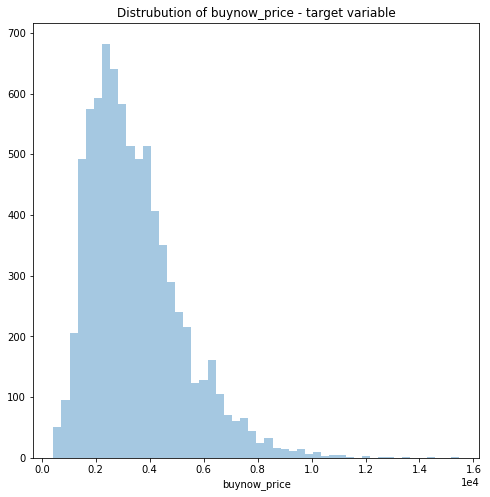

Skewness: 1.1918197625049383
Kurtosis: 2.2971867391894416


In [10]:
def plot_target_distribution(data, target_name):
    fig, ax = plt.subplots(figsize=(8,8))
    sns.distplot(data[target_name], kde=False)
    ax.set_title("Distrubution of buynow_price - target variable")
    ax.ticklabel_format(style='sci', axis='both', scilimits=(-3,3))
    plt.show()
    skew = data[target_name].skew()
    kurt = data[target_name].kurt()
    print(f'Skewness: {skew}\nKurtosis: {kurt}')
    
plot_target_distribution(
                        dataset, 
                        "buynow_price"
)

We can observe that our target variable:

* deviates from the normal distribution.
* shows peakedness.

We are going to divide features found in dataset based on their type:

In [11]:
numeric_features = [column for column,dtype in zip(dataset.columns, dataset.dtypes) if dtype == 'float64']

Let's take a look into contunous variables dependencies

/Users/lukaszbala/anaconda3/envs/allegroenv/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/lukaszbala/anaconda3/envs/allegroenv/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


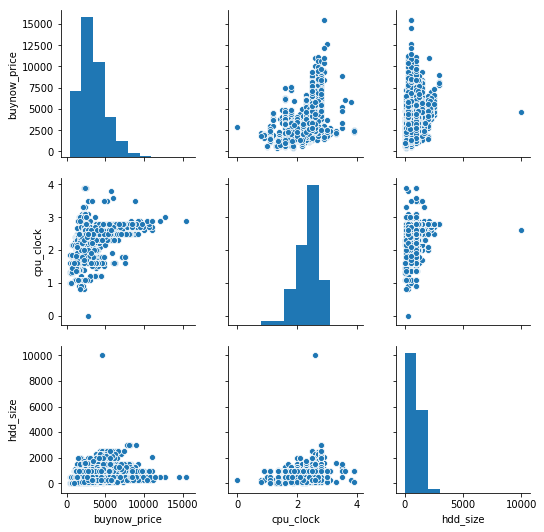

In [12]:
with warnings.catch_warnings():
    # Silencing warnings for missing data
    warnings.filterwarnings('ignore')
sns.pairplot(
            data=dataset, 
            x_vars=numeric_features,
            y_vars=numeric_features
)

What is apparent is the fact that one of hdd_size examples is definitely out of range as compare to other variables. We can also use boxplot to check whether it falls into this category.

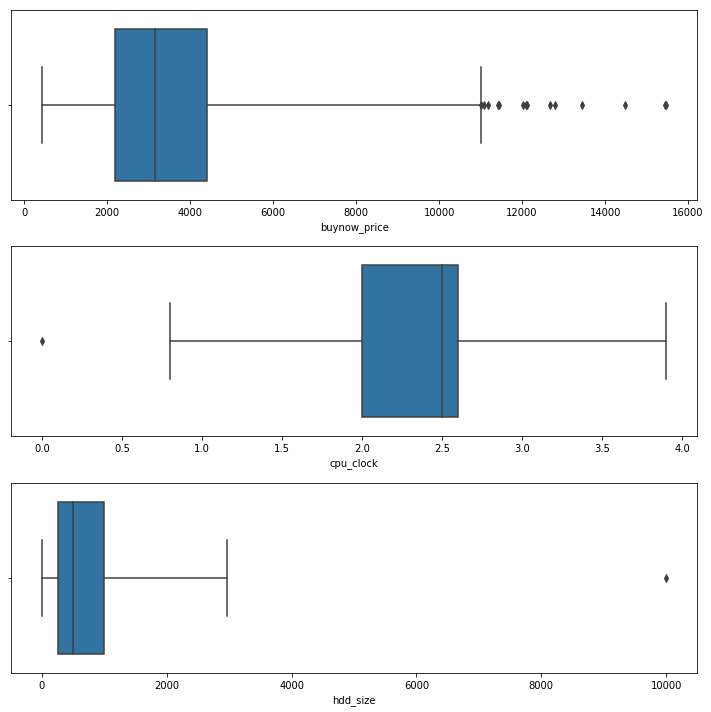

In [13]:
multipleplots(
              x = numeric_features, 
              data=dataset, 
              ncols=1, 
              nrows=3, 
              figsize=(10, 10), 
              plot_type='boxplot',
              whis=3
)
plt.tight_layout()

Some other points from the dataset were identified as outliers, however the one with huge hdd_size seems to be the most apparent one. We are going to investigate this examples further:

In [14]:
dataset.loc[dataset.loc[:, 'hdd_size'] > 5e3, :]

,index,buynow_price,gpu_type,communication,resolution,cpu_cores,ram_size,os,hdd_type,control,multimedia,ram_type,cpu_clock,cpu_series,state,hdd_size,warranty,screen_size
7644,9717,4597.0,grafika dedykowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1920 x 1080,4,16 gb,[windows 10 home],hdd,"[klawiatura, touchpad, klawiatura podświetlana...","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.6,intel core i7,nowy,10000.0,producenta,"15"" - 15.9"""


I couldn't find a laptop with internal hard drive capacity higher than 2TB, however there were laptops with such values in description as the one presented below:

https://allegro.pl/oferta/solidny-laptop-dell-inspiron-5758-17-cali-7901272449

but when looking into attached link from other hardware store:

https://www.x-kom.pl/p/250711-notebook-laptop-173-dell-inspiron-5758-i7-5500-8gb-1000-fhd-gf920m.html

one can see that it's actually 1TB hard drive, so I'm going to assume that this case is similar to the one presented here and assign 1TB value.

In [15]:
dataset.loc[dataset.loc[:, 'hdd_size'] > 5e3, 'hdd_size'] = 1e3

There is also the case with cpu_clock value equal to 0:

In [16]:
dataset.loc[dataset.loc[:, 'cpu_clock'] == 0, :]

,index,buynow_price,gpu_type,communication,resolution,cpu_cores,ram_size,os,hdd_type,control,multimedia,ram_type,cpu_clock,cpu_series,state,hdd_size,warranty,screen_size
1305,125,2825.0,grafika zintegrowana,"[lan 10/100/1000 mbps, nfc (near field communi...",1920 x 1080,2,8 gb,[windows 8.1 home 64-bit],ssd,"[klawiatura, touchpad]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3l,0.0,intel core i7,nowy,256.0,producenta,"14"" - 14.9"""


We are going to treat this example as missing value in our further analysis

In [17]:
dataset.loc[dataset.loc[:, 'cpu_clock'] == 0, 'cpu_clock'] = None

Furthermore we would like to investigate relationship between cpu_clock and hdd_size in a more detailed way, since we suspect that they can be significant indicators of the price and it was not so visible in the case of pairplot:

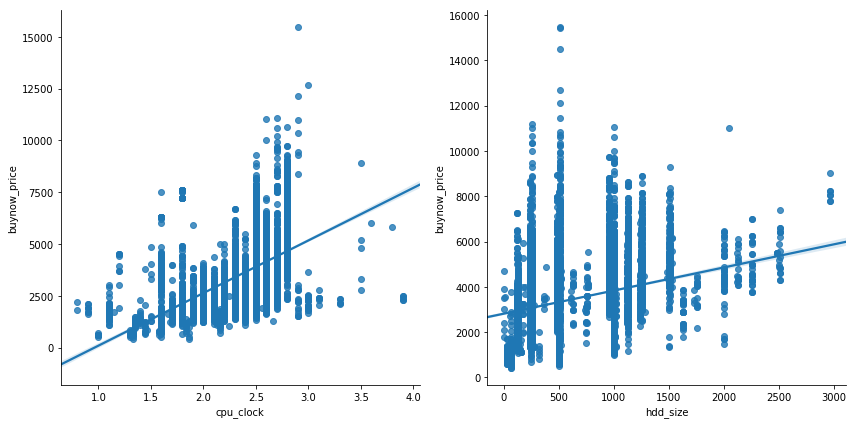

In [18]:
multipleplots(
              data=dataset,
              x=['cpu_clock', 'hdd_size'],
              y='buynow_price',
              nrows=1,
              ncols=2,
              figsize=(12, 6), 
              plot_type='regplot'
)
sns.despine()
plt.tight_layout()

What we can observe from the above graphs is as follows:
* There are clear groups in case of hard drive capacity (we can clearly distinguish 256GB, 512GB etc.)
* cpu_clock seems to have more importance than hdd_size, although the approximation to the negative prices seen on the graph may by misleading

## 3.2 Categorical features <a name='categorical'></a>

In [19]:
cat_features = [column for column,dtype in zip(dataset.columns, dataset.dtypes) if dtype == 'object']
list_features = ['multimedia', 'communication', 'os', 'control']

We are going to need 14 graphs to show all categorical variables from our dataset, although there are some that contain list type variables, which cannot be used in default seaborn barplot, so I decided to leave them out. Furthermore, for the purposes of readability, I decided to plot resulution and cpu_series on seperate graph.

In [20]:
cat_features_unlist = [feature for feature in cat_features if feature not in list_features+['cpu_series', 'resolution']]

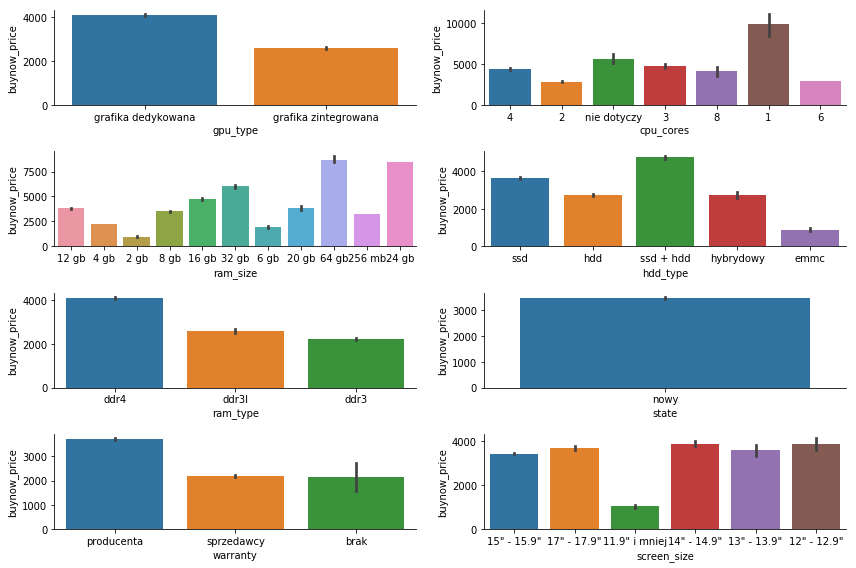

In [21]:
multipleplots(
              data=dataset,
              x=cat_features_unlist,
              y='buynow_price',
              nrows=4,
              ncols=2,
              figsize=(12, 8), 
              plot_type='barplot'
)
sns.despine()
plt.tight_layout()

There several things to notice from this plot:

* Warranty from producer is preferable to the seller's one.
* There are only new laptops in this dataset, so actually we can just drop this variable.
* Only if the screen is really small the price really varies.
* There is a category in cpu_cores visible which states "nie dotyczy". We are going to investigate this class further.
* The more ram, the bigger the price
* GPU dedicated to the laptop makes its price higher on average, which follows the notion the such GPU's are usually faster than integrated ones.

Plotting remaining two categories:

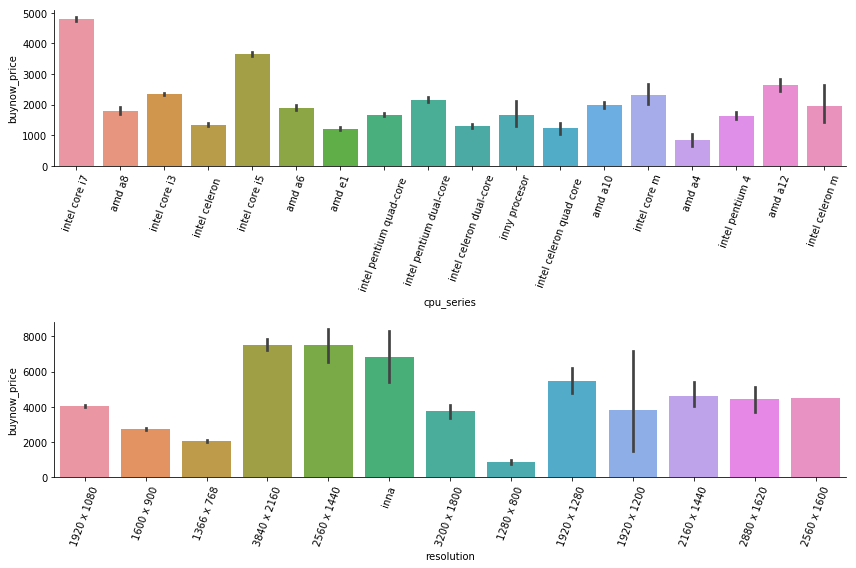

In [22]:
multipleplots(
              data=dataset,
              x=['cpu_series', 'resolution'],
              y='buynow_price',
              nrows=2,
              ncols=1,
              figsize=(12, 8), 
              plot_type='barplot',
              rotation=70
)
sns.despine()
plt.tight_layout()

As in aforementioned statemenent concerning Intel vs AMD competition, one can see that i7 and i5 CPUs correspond to more expensive laptops, both having higher average price than the most prestigous from AMD CPUs - a12 model.

As mentioned before, we will drop the "state" variable, since it doesn't give us any additional information. Moreover we are going to start using prefix "pre" for preprocessed data.

In [23]:
dataset_pre = dataset[dataset.columns.difference(['state'])]

## 4. Missing values <a name='missing'></a>

## 4.1 Identifying Nones in dataset <a name='identify'></a>

As mentioned in our analysis of categorical features, we are going to investigate case of "nie dotyczy" category in cpu_cores variable.

In [24]:
dataset_pre.loc[dataset_pre.loc[:, "cpu_cores"] == "nie dotyczy", :].head(10)

,buynow_price,communication,control,cpu_clock,cpu_cores,cpu_series,gpu_type,hdd_size,hdd_type,index,multimedia,os,ram_size,ram_type,resolution,screen_size,warranty
51,6450.0,None,None,NaN,nie dotyczy,None,None,NaN,None,10077,None,None,None,None,None,None,producenta
85,4899.0,"[bluetooth, nfc (near field communication)]",None,1.8,nie dotyczy,None,grafika zintegrowana,NaN,None,10127,None,[windows 10 home],8 gb,None,None,None,producenta
223,2868.9,None,None,NaN,nie dotyczy,None,None,NaN,None,10320,None,None,None,None,None,None,producenta
452,2497.9,None,None,NaN,nie dotyczy,None,None,NaN,None,1064,None,None,None,None,None,None,producenta
534,6750.0,None,None,NaN,nie dotyczy,None,None,NaN,None,10744,None,None,None,None,None,None,producenta
541,6160.0,None,None,NaN,nie dotyczy,None,None,NaN,None,10751,None,None,None,None,None,None,producenta
636,6158.9,None,None,NaN,nie dotyczy,None,None,NaN,None,10869,None,None,None,None,None,None,producenta
647,2868.9,None,None,NaN,nie dotyczy,None,None,NaN,None,10883,None,None,None,None,None,None,producenta
665,2910.0,None,None,NaN,nie dotyczy,None,None,NaN,None,10911,None,None,None,None,None,None,producenta
712,10180.0,None,None,NaN,nie dotyczy,None,None,NaN,None,10972,None,None,None,None,None,None,producenta


We can see that majority of these examples correponds to the cases when most of the features are missing. We are going to see how many such cases actually exist in the dataset.

In [25]:
missing = dataset_pre.loc[dataset_pre.isnull().sum(axis=1)/dataset_pre.shape[1] > 0.75, :]
missing.isnull().sum()

buynow_price       0
communication    255
control          255
cpu_clock        255
cpu_cores          0
cpu_series       255
gpu_type         255
hdd_size         255
hdd_type         255
index              0
multimedia       255
os               255
ram_size         255
ram_type         255
resolution       255
screen_size      255
warranty           0
dtype: int64

There are 255 examples with missing values higher than 75%. Moreover we can see that besides state of the laptop and warranty type there is not much in this part of dataset. We are going to remove these examples from the dataset.

In [26]:
#TODO - consider not removing missing values
dataset_pre = dataset_pre.loc[~dataset_pre['index'].isin(missing['index']), :]

Remaining examples are presented below:

In [27]:
dataset_pre.loc[dataset_pre.loc[:, "cpu_cores"] == "nie dotyczy", :]

,buynow_price,communication,control,cpu_clock,cpu_cores,cpu_series,gpu_type,hdd_size,hdd_type,index,multimedia,os,ram_size,ram_type,resolution,screen_size,warranty
85,4899.0,"[bluetooth, nfc (near field communication)]",None,1.8,nie dotyczy,None,grafika zintegrowana,NaN,None,10127,None,[windows 10 home],8 gb,None,None,None,producenta
1191,6299.0,"[bluetooth, nfc (near field communication)]",None,1.6,nie dotyczy,None,grafika zintegrowana,NaN,None,11645,None,[windows 10 home],8 gb,None,None,None,producenta
4013,3349.0,None,"[klawiatura, touchpad, klawiatura podświetlana...",NaN,nie dotyczy,intel core i5,grafika dedykowana,NaN,hdd,4878,None,[windows 10 professional],8 gb,None,None,"15"" - 15.9""",brak
4965,1399.0,None,None,NaN,nie dotyczy,intel celeron,grafika dedykowana,NaN,hdd,6136,None,None,4 gb,ddr3,1366 x 768,None,producenta


Since there are only 4 such examples (and moreover cpu_clock and cpu_series values indicate so), we are going to fill them with mode of this category, which is equal to 2.

In [28]:
dataset_pre.loc[dataset_pre.loc[:, "cpu_cores"] == "nie dotyczy", 'cpu_cores'] = \
dataset_pre.loc[:, 'cpu_cores'].mode()[0]

dataset_test.loc[dataset_test.loc[:, "cpu_cores"] == "nie dotyczy", 'cpu_cores'] = \
dataset_test.loc[:, 'cpu_cores'].mode()[0]

With dataset prepared in the way presented above we are going to check whether there are some missing values in the rest of it. And the plot all of these variables that contain some missing part.

               Total   Percent
cpu_clock        682  0.089760
ram_type         609  0.080153
communication    527  0.069360
multimedia       453  0.059621
control          423  0.055673
os               395  0.051987


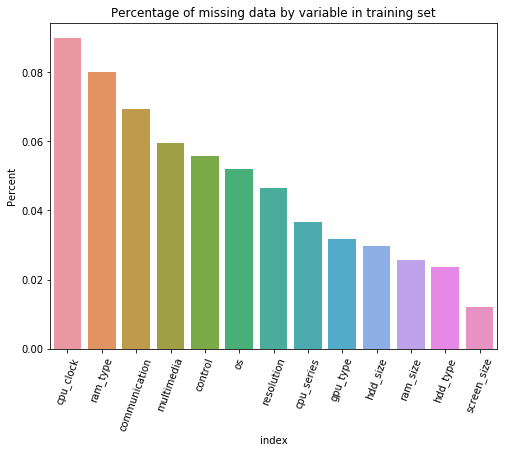

In [29]:
plot_missing_values(missing_values(dataset_pre),"Percentage of missing data by variable in training set")

               Total   Percent
cpu_clock        451  0.116568
ram_type         415  0.107263
communication    401  0.103644
multimedia       356  0.092013
control          332  0.085810
os               322  0.083226


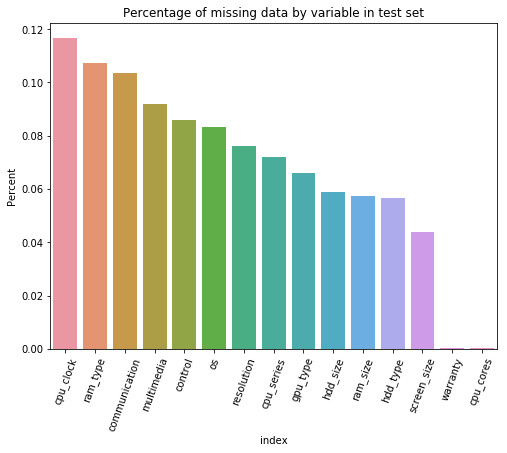

In [30]:
plot_missing_values(missing_values(dataset_test),"Percentage of missing data by variable in test set")

So one can see that the distribution of missing values is similar both in training and test set. Moreover, there are no missing values of target variable in our training set. From the above graphs the most concerning missing values are those associated with CPU and RAM.

Checking value counts for each cpu_series:

In [31]:
dataset_pre['cpu_series'].value_counts()

intel core i5               2595
intel core i7               2324
intel core i3               1399
amd a6                       195
intel pentium dual-core      175
intel celeron dual-core      170
intel celeron                120
intel pentium quad-core       87
inny procesor                 70
amd a8                        42
amd a10                       29
intel celeron quad core       27
amd e1                        22
amd a12                       21
intel pentium 4               15
intel core m                  12
amd a4                        11
intel celeron m                6
Name: cpu_series, dtype: int64

Since already the dominating classes are i5 and i7 processors and the number of missing values in this case in not very high, we are going to fill them with most frequent one (i5 series).

In [32]:
dataset_pre['cpu_series'] = dataset_pre['cpu_series'].fillna(dataset_pre['cpu_series'].value_counts().index[0])
dataset_test['cpu_series'] = dataset_test['cpu_series'].fillna(dataset_test['cpu_series'].value_counts().index[0])

After that we plan to impute missing values of cpu clock with mean value of each cpu_series, since its quite common that, for example, i3 series has lower operating frequency than CPUs from i7 series.

In [33]:
#TODO - plot these values
print(dataset_pre.groupby(['cpu_series'])['cpu_clock'].agg('mean'),
      dataset_test.groupby(['cpu_series'])['cpu_clock'].agg('mean'), sep="\n")

cpu_series
amd a10                     2.222222
amd a12                     2.690476
amd a4                      1.263636
amd a6                      1.962827
amd a8                      1.987805
amd e1                      1.364286
inny procesor               1.679655
intel celeron               1.553043
intel celeron dual-core     1.795032
intel celeron m             1.370000
intel celeron quad core     1.462800
intel core i3               2.114509
intel core i5               2.378361
intel core i7               2.635796
intel core m                0.977778
intel pentium 4                  NaN
intel pentium dual-core     2.045562
intel pentium quad-core     1.510704
Name: cpu_clock, dtype: float64
cpu_series
amd a10                     2.111111
amd a12                     2.687500
amd a4                      1.525000
amd a6                      1.993578
amd a8                      2.030000
amd e1                      1.363636
inny procesor               1.591667
intel celeron        

Our preliminiary notions are clearly represented in the data, visible both for AMD and Intel processors. The only problem remains with Pentium 4 series, which does not have assigned frequency in any case represented. Maybe not everyone remembers that, but Pentium 4 processors possesed very high operational frequency values (up to 4 ghz), so we are going to impute them with max value of the resulting dataset. From our previous analysis we can see that it's going to be 3.9 ghz.

In [34]:
dataset_pre['cpu_clock'] = dataset_pre.groupby(['cpu_series'])['cpu_clock'].transform(lambda x: x.fillna(x.mean()))
#Filling for remaining Pentium 4 series
dataset_pre['cpu_clock'] = dataset_pre['cpu_clock'].fillna(dataset_pre['cpu_clock'].max())

dataset_test['cpu_clock'] = dataset_test.groupby(['cpu_series'])['cpu_clock'].transform(lambda x: x.fillna(x.mean()))
#Filling for remaining Pentium 4 series
dataset_test['cpu_clock'] = dataset_test['cpu_clock'].fillna(dataset_test['cpu_clock'].max())

Similar approach, although not as well justified, will be applied to hard drives, RAM and screen size.

In [35]:
print("Count of laptops per hard drive type:", dataset_pre['hdd_type'].value_counts(),"\n", sep="\n")
dataset_pre['hdd_type'] = dataset_pre['hdd_type'].fillna(dataset_pre['hdd_type'].value_counts().index[0])
print("Average hard drive size per type:", dataset_pre.groupby(['hdd_type'])['hdd_size'].agg('mean'), sep="\n")
dataset_pre['hdd_size'] = dataset_pre.groupby(['hdd_type'])['hdd_size'].transform(lambda x: x.fillna(x.mean()))

dataset_test['hdd_type'] = dataset_test['hdd_type'].fillna(dataset_test['hdd_type'].value_counts().index[0])
dataset_test['hdd_size'] = dataset_test.groupby(['hdd_type'])['hdd_size'].transform(lambda x: x.fillna(x.mean()))

Count of laptops per hard drive type:
ssd          3762
hdd          2330
ssd + hdd    1147
emmc           93
hybrydowy      86
Name: hdd_type, dtype: int64


Average hard drive size per type:
hdd_type
emmc           47.816092
hdd           875.991961
hybrydowy     809.753425
ssd           336.247206
ssd + hdd    1321.956483
Name: hdd_size, dtype: float64


We are moving to filling categorical variables now - instead of average value per group, our imputer is going to be the most frequent value per group

In [36]:
dataset_pre['resolution'].value_counts()

1920 x 1080    4547
1366 x 768     2100
1600 x 900      363
3840 x 2160     123
2560 x 1440      34
1920 x 1280      31
1280 x 800       16
3200 x 1800      15
2160 x 1440       5
2880 x 1620       4
1920 x 1200       4
inna              2
2560 x 1600       1
Name: resolution, dtype: int64

In [37]:
for imputer, var_to_fill in zip(['screen_size', 'ram_type'], ['resolution', 'ram_size']):
    print(f"Count of laptops per {imputer}:", dataset_pre[imputer].value_counts(),"\n", sep="\n")
    dataset_pre[imputer] = dataset_pre[imputer].fillna(dataset_pre[imputer].value_counts().index[0])
    print(f"Most frequent {var_to_fill} per {imputer}:", \
          dataset_pre.groupby([imputer])[var_to_fill].agg(lambda x: x.value_counts().index[0]),"\n", sep="\n")
    dataset_pre[var_to_fill] = dataset_pre.groupby([imputer])[var_to_fill].transform(lambda x: x.fillna(x.mode()[0]))
    
dataset_test[imputer] = dataset_test[imputer].fillna(dataset_test[imputer].value_counts().index[0])
dataset_test[var_to_fill] = dataset_test.groupby([imputer])[var_to_fill].transform(lambda x: x.fillna(x.mode()[0]))

Count of laptops per screen_size:
15" - 15.9"      5309
14" - 14.9"       888
17" - 17.9"       852
13" - 13.9"       209
11.9" i mniej     156
12" - 12.9"        93
Name: screen_size, dtype: int64


Most frequent resolution per screen_size:
screen_size
11.9" i mniej     1366 x 768
12" - 12.9"      1920 x 1080
13" - 13.9"      1920 x 1080
14" - 14.9"      1920 x 1080
15" - 15.9"      1920 x 1080
17" - 17.9"      1920 x 1080
Name: resolution, dtype: object


Count of laptops per ram_type:
ddr4     4533
ddr3     1769
ddr3l     687
Name: ram_type, dtype: int64


Most frequent ram_size per ram_type:
ram_type
ddr3     8 gb
ddr3l    8 gb
ddr4     8 gb
Name: ram_size, dtype: object




In [38]:
dataset_pre.isnull().sum()

buynow_price       0
communication    527
control          423
cpu_clock          0
cpu_cores          0
cpu_series         0
gpu_type         241
hdd_size           0
hdd_type           0
index              0
multimedia       453
os               395
ram_size           0
ram_type           0
resolution         0
screen_size        0
warranty           0
dtype: int64

We are going to leave GPU as None type, since there is hardly any variable that we can directly associate with. The rest of missing variables are from features with list type values and they are going to be one-hot encoded later in the notebook

## 5. Comparing distribution of features of training and test set<a name='compare'></a>

When one wants to predict a value of certain variable, we should make sure that distrubtion from all datasets that are used are coming from the same distribution. We are going to use Population Stability Index in order to verify whether these two samples come from similar distribution

## 6. Encoding of categorical variables<a name='encoding'></a>

In [39]:
dataset_X = dataset_pre.loc[:, dataset_pre.columns != 'buynow_price']
dataset_Y = dataset_pre.loc[:,'buynow_price']

We are going to unlist operational system, as there is only one value per each row, to later encode this variable. Moreover we are going to change size of RAM memory to numerical variable and state of the laptop to binary one.

In [40]:
dataset_X.loc[:,'os'] = dataset_X.loc[:,'os'].apply(lambda x: x[0] if x is not None else x)
dataset_X.loc[:, 'ram_size'] = dataset_X.loc[:, 'ram_size'].apply(lambda x: float(x.split()[0]) if x is not None else x)
dataset_X.loc[:, 'cpu_cores'] = dataset_X.loc[:, 'cpu_cores'].apply(lambda x: float(x) if x is not None else x)

dataset_test.loc[:,'os'] = dataset_test.loc[:, 'os'].apply(lambda x: x[0] if x is not None else x)
dataset_test.loc[:, 'ram_size'] = dataset_test.loc[:, 'ram_size'].apply(lambda x: float(x.split()[0]) if x is not None else x)
dataset_test.loc[:, 'cpu_cores'] = dataset_test.loc[:, 'cpu_cores'].apply(lambda x: float(x) if x is not None else x)

/Users/lukaszbala/anaconda3/envs/allegroenv/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Since all variables that from preliminiary inpection contained list-type objects posses some information about additional items or features (like bluetooth or keyboard) we are going to treat them as one-hot encoded variables. The resulting Nones from pd.merge are going to be imputed with 0.

## 6.1 One-hot encoding<a name='onehot'></a>

In [41]:
list_type_variables = ['communication', 'control', 'multimedia']
one_hot = [list_to_one_hot(dataset_X, var, 'index') for var in list_type_variables]
dataset_X_one_hot = reduce(lambda left,right: pd.merge(left,right,on='index', how='left') \
                           .fillna(0, downcast='infer'), [dataset_X, *one_hot])
dataset_X_one_hot = dataset_X_one_hot[dataset_X_one_hot.columns.difference([*list_type_variables, 'index'])]


dataset_test_one_hot = reduce(lambda left,right: pd.merge(left,right,on='index', how='left') \
                           .fillna(0, downcast='infer'), [dataset_test, *one_hot])
dataset_test_one_hot = dataset_test_one_hot[dataset_test_one_hot.columns.difference([*list_type_variables, 'index'])]

From remaining categorical featues we are going to extract values from target encoding

In [42]:
names_trans = ["gpu_type", "resolution", "hdd_type", "ram_type", "cpu_series", 
               "warranty", "screen_size", "os"]

## 6.2 Target encoding within preprocessing pipeline<a name='target'></a>

In [43]:
preprocess_pipeline = make_pipeline(
    ColumnProjector(),
    CategoricalGrouper(new_cat='OtherCategories'),
    FeatureUnion(transformer_list=[
        ('num_feat', make_pipeline(
            TypeSelector('number'),
            StandardScaler()
        )),
        ('bool_feat', TypeSelector(bool)),
        ('cat_feat', make_pipeline(
            TypeSelector('category'),
            TargetEncoder(cv=20, inner_cv=10, alpha=5, random_state=42),
            StandardScaler()
        ))
    ])
)

In [44]:
preprocess_pipeline.fit(dataset_X_one_hot, dataset_Y)
dataset_X_en_pre = pd.DataFrame(preprocess_pipeline.transform(dataset_X_one_hot),
                                columns=dataset_X_one_hot.columns)

#TODO - deal with one more category on test set

with warnings.catch_warnings():
    #Silence data scaling warning
    warnings.filterwarnings('ignore')

/Users/lukaszbala/anaconda3/envs/allegroenv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


## 7. Correlations between features<a name='corr'></a>

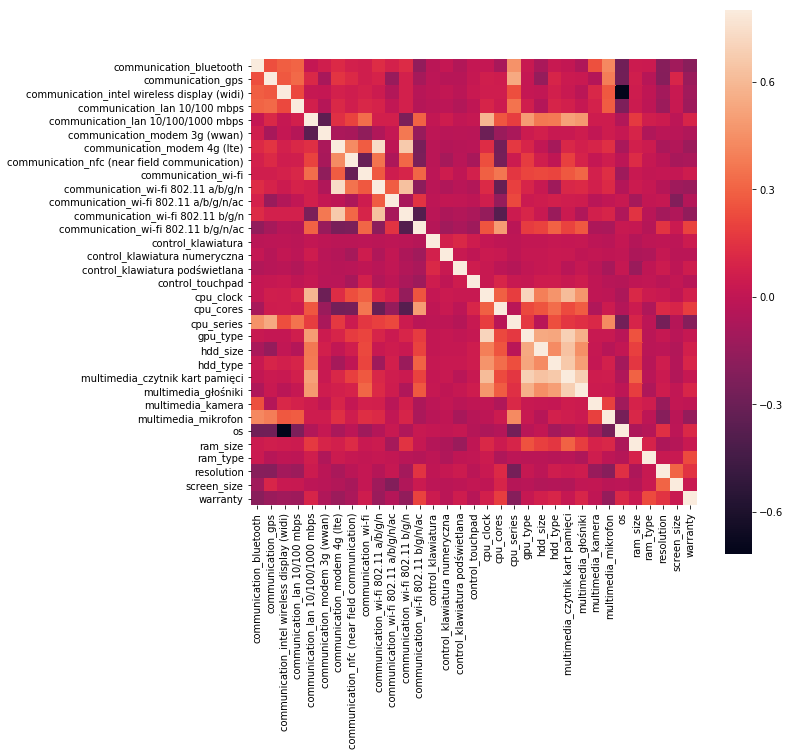

In [45]:
corrmat = dataset_X_en_pre.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data=corrmat, vmax=.8, square=True)
plt.show()

Showing 20 most correlated pairs

In [46]:
get_top_abs_correlations(corrmat, num_of_features = 20)

communication_intel wireless display (widi)  os                                    0.954724
gpu_type                                     multimedia_czytnik kart pamięci       0.947460
communication_modem 4g (lte)                 communication_wi-fi 802.11 a/b/g/n    0.941001
multimedia_czytnik kart pamięci              multimedia_głośniki                   0.926153
communication_lan 10/100/1000 mbps           cpu_clock                             0.900882
cpu_clock                                    gpu_type                              0.900630
hdd_size                                     multimedia_czytnik kart pamięci       0.890633
hdd_type                                     multimedia_czytnik kart pamięci       0.882410
gpu_type                                     multimedia_głośniki                   0.878464
cpu_clock                                    multimedia_czytnik kart pamięci       0.866083
gpu_type                                     hdd_size                           

## 8. Training and validation split<a name='traintest'></a>

Since we would prefer not to overfit our model, we are going to split our training set into training and validation set. We are going to use standard 80/20 ratio, since then our training set will still be bigger than test set and validation set is going to have about 40% of number of records from test set, so the proportions of records are within reasonable range.

In [47]:
X_train_pre, X_val_pre, Y_train_pre, Y_val_pre = train_test_split(dataset_X_en_pre, dataset_Y, 
                                                          test_size=0.2, random_state=seed)

## 9. RMSE<a name='rmse'></a>

Here we define our metric which is going to be used as a benchmark for this data

In [48]:
def rmse(y_true, y_pred):
    mse = np.mean((y_pred - y_true)** 2)
    return np.sqrt(mse)

rmse_score = make_scorer(rmse, greater_is_better=False)

## 10. Modelling<a name='modelling'></a>

## 10.1 Linear regression<a name='lr'></a>

Firstly we are going to perform the simplest form of linear regression as our benchmark. We added variance inflation factor to avoid multicollinear features.

In [49]:
vif = VIFSelector(thresh=5.)
X_train_lr = vif.fit_transform(X_train_pre)

lr = LinearRegression()
lr.fit(X_train_lr, Y_train_pre)
pred = lr.predict(X_val_pre.loc[:, X_train_lr.columns])
rmse(pred, Y_val_pre)

1063.0909381835056

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text xticklabel objects>)

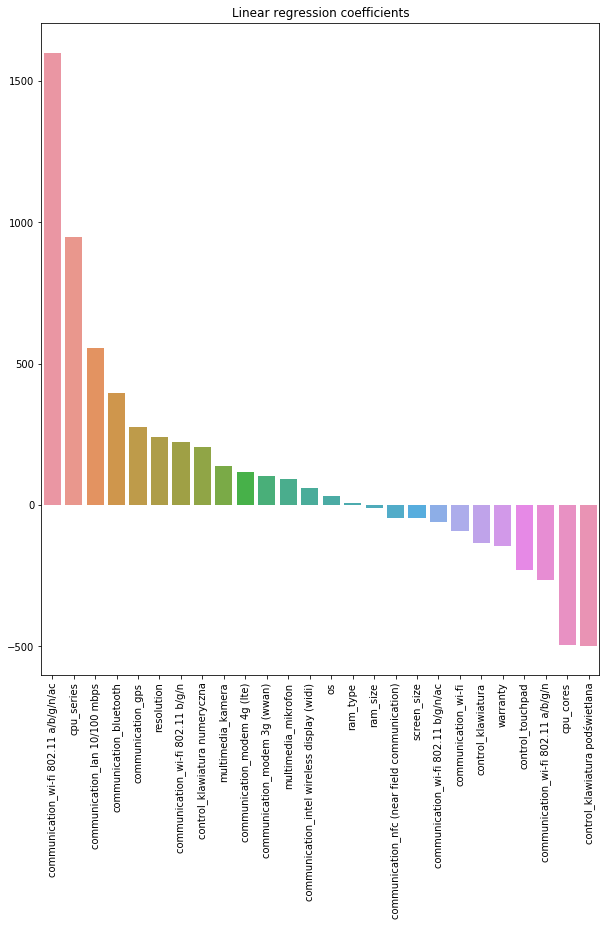

In [50]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,12))
#Assigning names to coefficients and sorting
coef_names = list(zip(lr.coef_, X_train_lr.columns))
coef_names.sort(reverse=True);
#Transposing a list of lists
coef_names = list(map(list, zip(*coef_names)))
sns.barplot(x = coef_names[1], y=coef_names[0])
plt.title("Linear regression coefficients")
plt.xticks(rotation=90)

## 10.2 Xgboost <a name='xgboost'></a>

Without hyperparameter tuning

In [51]:
xgbr = xgb.XGBRegressor()
xgbr.fit(X_train_pre, Y_train_pre)
pred = xgbr.predict(X_val_pre)
rmse(pred, Y_val_pre)

644.8379262924325

<module 'matplotlib.pyplot' from '/Users/lukaszbala/anaconda3/envs/allegroenv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

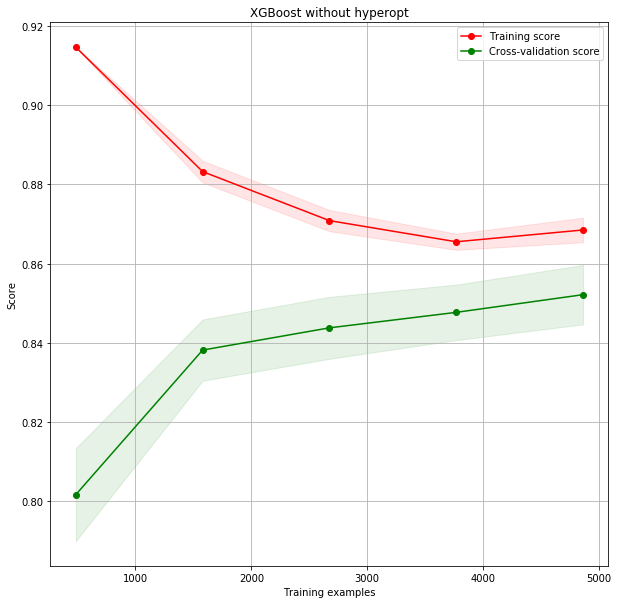

In [52]:
plot_learning_curve(X=X_train_pre, y = Y_train_pre, estimator=xgbr, cv=5, title="XGBoost without hyperopt")

With hyperparameter tuning

In [54]:
EXPERIMENT_NAME = 'xgboost_first'

In [55]:
space = {
        'max_depth': hp.choice("max_depth", range(1, 13, 1)),
        'min_child_weight': hp.quniform ('min_child', 1, 10, 1),
        'subsample': hp.uniform ('subsample', 0.7, 1),
        'gamma' : hp.uniform ('gamma', 0.,0.5),
        'colsample_bytree' : hp.uniform ('colsample_bytree', 0.4,1),
        'reg_lambda' : hp.uniform ('reg_lambda', 0,1),
        'colsample_bylevel': hp.uniform('colsample_bylevel',0.4,1),
        'colsample_bynode' : hp.uniform('colsample_bynode',0.4,1),
        'reg_alpha': hp.uniform('reg_alpha',0,1)
        }

In [56]:
reg_optim = RegressorOptimizer(
    regressor=xgbr,
    space=space,
    metric=rmse
)

We are going to make sure that our model is not overfitting by adding penalty value in cases, where prediction on validation set has more than 30% higher rmse than in case of training set. We added this penalty due to the fact that on previous training of this model we observed that it has great tendency to overfit. The model was run before, with about 500 evaluations before.

In [57]:
reg_optim.find_best_params(
    X_train_pre.values,
    Y_train_pre.values,
    experiments_path='../experiments/',
    experiments_name=EXPERIMENT_NAME,
    max_evals=2000,
    overfit_penalty=0.3
)

Train: 332.2711, valid: 516.2295                      
Train: 322.0424, valid: 508.6322                                              
Train: 616.9119, valid: 656.7467                                              
Train: 433.9833, valid: 543.2839                                              
Train: 330.0051, valid: 513.9165                                              
Train: 339.5962, valid: 517.6655                                              
Train: 324.8533, valid: 506.8485                                              
Train: 405.1530, valid: 532.1607                                              
Train: 191.5142, valid: 496.1525                                              
Train: 574.2232, valid: 627.1017                                              
Train: 435.8534, valid: 547.9022                                               
Train: 265.9517, valid: 495.8530                                               
Train: 428.2480, valid: 540.6679                                          

In [58]:
trials = pickle.load(open(os.path.join('../experiments/', '.'.join([EXPERIMENT_NAME, 'hpopt'])), 'rb'))

Extracting hyperparameters from the best trial

In [59]:
params = reg_optim.space_eval(trials.best_trial)
xgbr_hp = xgb.XGBRegressor(**params)
xgbr_hp.fit(X_train_pre, Y_train_pre)
pred = xgbr_hp.predict(X_val_pre)
rmse(pred, Y_val_pre)

511.1365574443578

<module 'matplotlib.pyplot' from '/Users/lukaszbala/anaconda3/envs/allegroenv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

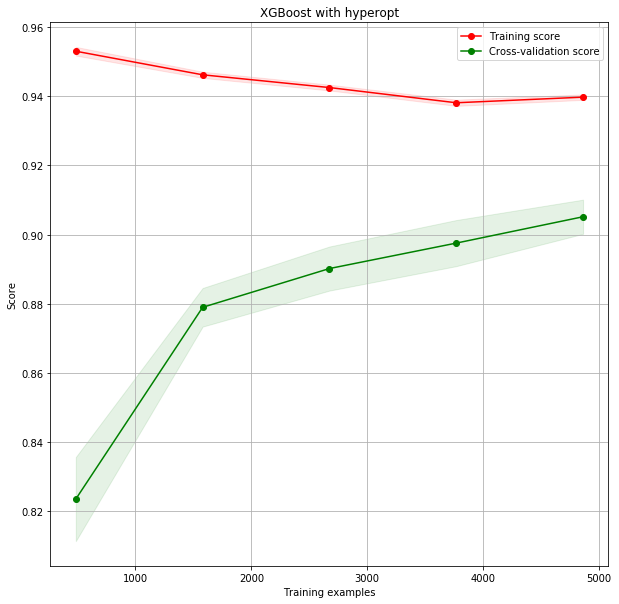

In [60]:
plot_learning_curve(X=X_train_pre, y = Y_train_pre, estimator=xgbr_hp, cv=5, title="XGBoost with hyperopt")

So one can see that our rmse score was about 20% lower after hyperparameter optimisation with Bayesian approach and additional penalty to the model.

## 10.3 Explaining prediction of XGBoost<a name='expxgboost'></a>

From documentation:
<br>
"SHAP (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model. 
SHAP connects game theory with local explanations, 
uniting several previous methods and representing the only possible consistent and locally accurate additive feature attribution method based on expectations 
(see the SHAP NIPS paper for details)."

In case of our XGBRegressor, feature importance was based on "gain", which can be understood as the average training loss reduction gained when using a feature for splitting. There two other ways to explain xgboost features ("cover" and "weight"), but results from them are usually inconsistent

In [ ]:
importance_type = ['weight', 'gain', 'cover']
for importance in importance_type:
    xgb.plot_importance(
                        xgbr_hp,
                        max_num_features=10, 
                        importance_type=importance, 
                        show_values=False, 
                        xlabel="Importance",
                        title=f"Feature importance measured by {importance}"
    )

One can see that there is no consistent result in this particular case (although cpu_series and hdd_size are the most common ones, which is not surprising)

In [ ]:
shap_values = shap.TreeExplainer(xgbr_hp).shap_values(X_val_pre)
shap_interaction_values = shap.TreeExplainer(xgbr_hp).shap_interaction_values(X_val_pre)

In [ ]:
shap.summary_plot(shap_values, X_val_pre)

## 10.4 CatBoost<a name='catboost'></a>

In case of CatBoost we will firstly try not to use any type of encoding, since this algorithm can deal with such variables on the fly. We can need to convert int type values to float ones.

In [ ]:
dataset_X_cat = dataset_X_one_hot
integer_columns = dataset_X_cat.select_dtypes('int').columns
dataset_X_cat.loc[:, integer_columns] = \
dataset_X_cat.astype({integer: float for integer in dataset_X_cat.loc[:, integer_columns]})
X_train_cat, X_val_cat, Y_train_cat, Y_val_cat = train_test_split(dataset_X_cat, dataset_Y,
                                                                  test_size=0.2, random_state=seed)

In [ ]:
ctb=CatBoostRegressor(iterations=1000, depth=3, learning_rate=0.1, loss_function='RMSE', verbose=0)
ctb.fit(X_train_cat, Y_train_cat,cat_features=names_trans,eval_set=(X_val_cat, Y_val_cat),plot=True)

TODO Bayesian optimisation of Catboost

## 11. Summary<a name='summary'></a>